In [ ]:
!pip install catboost
!pip install pdpbox
!pip install miceforest
!pip install fancyimpute

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from glob import glob
import os, random, time, gc, warnings
from tqdm import tqdm_notebook
import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.cluster import KMeans
from datetime import datetime
from math import sqrt
import folium
from folium import Marker, Icon, CircleMarker
from sklearn.model_selection import train_test_split
from pdpbox import pdp, info_plots
from fancyimpute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import miceforest as mf
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [3]:
import os, sys
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
default_dir = "/content/gdrive/My Drive"
df_train = pd.read_csv(os.path.join(default_dir,"train.csv")) # 학습용 데이터
df_test = pd.read_csv(os.path.join(default_dir,"submission.csv")) # 테스트 데이터(제출파일의 데이터)

In [5]:
df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [6]:
df_train.shape

(59299, 29)

In [7]:
df_train.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner
count,59299.000000,14568.000000,59299.000000,13756.000000,3444.0,1121.0,4565.0,59299.000000,59299.000000,59299.000000,18417.000000,15304.000000,59299.000000
mean,0.634593,0.091685,27114.556333,19.912184,1.0,1.0,1.0,79.271590,0.041603,0.050810,0.001117,0.049288,262.563888
std,0.286066,0.150988,14653.911888,44.697938,0.0,0.0,0.0,132.551067,0.199681,0.219612,0.001104,0.027949,231.605681
min,0.000000,0.003788,2.000000,0.000000,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000
25%,0.500000,0.019900,14913.000000,1.000000,1.0,1.0,1.0,7.000000,0.000000,0.000000,0.000298,0.026846,97.000000
50%,0.500000,0.049180,26774.000000,4.000000,1.0,1.0,1.0,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000
75%,1.000000,0.074949,40368.500000,19.000000,1.0,1.0,1.0,92.000000,0.000000,0.000000,0.001183,0.064566,374.000000
max,1.000000,1.000000,47466.000000,1394.000000,1.0,1.0,1.0,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000


In [8]:
df_train.isnull().sum().to_frame('nan_count')

,nan_count
bant_submit,0
customer_country,982
business_unit,0
com_reg_ver_win_rate,44731
customer_idx,0
customer_type,43961
enterprise,0
historical_existing_cnt,45543
id_strategic_ver,55855
it_strategic_ver,58178


In [9]:
pd.DataFrame(data=df_train.isnull().sum()/len(df_train),columns=['nan_ratio'])

,nan_ratio
bant_submit,0.000000
customer_country,0.016560
business_unit,0.000000
com_reg_ver_win_rate,0.754330
customer_idx,0.000000
customer_type,0.741345
enterprise,0.000000
historical_existing_cnt,0.768023
id_strategic_ver,0.941921
it_strategic_ver,0.981096


Text(0.5, 1.0, 'Total Missing Value (%)')

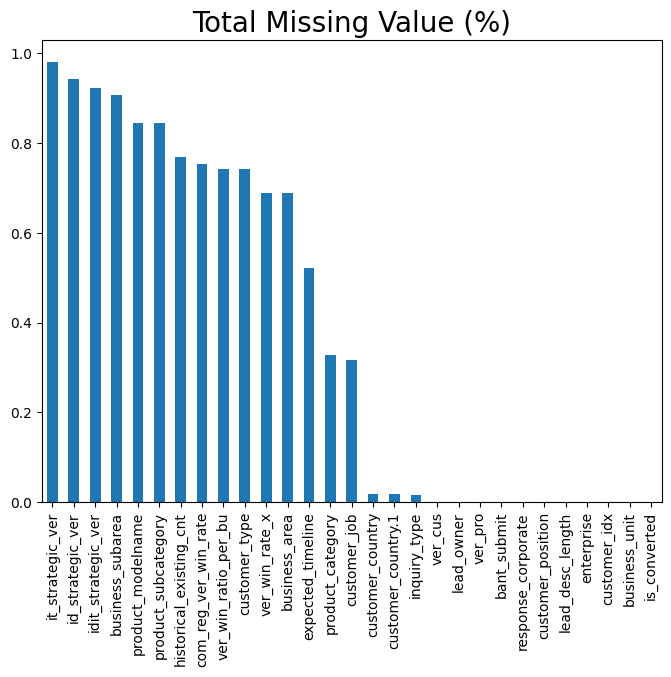

In [10]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
percent_data = percent.head(30)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

Text(0.5, 1.0, 'Correlation with Missing Values')

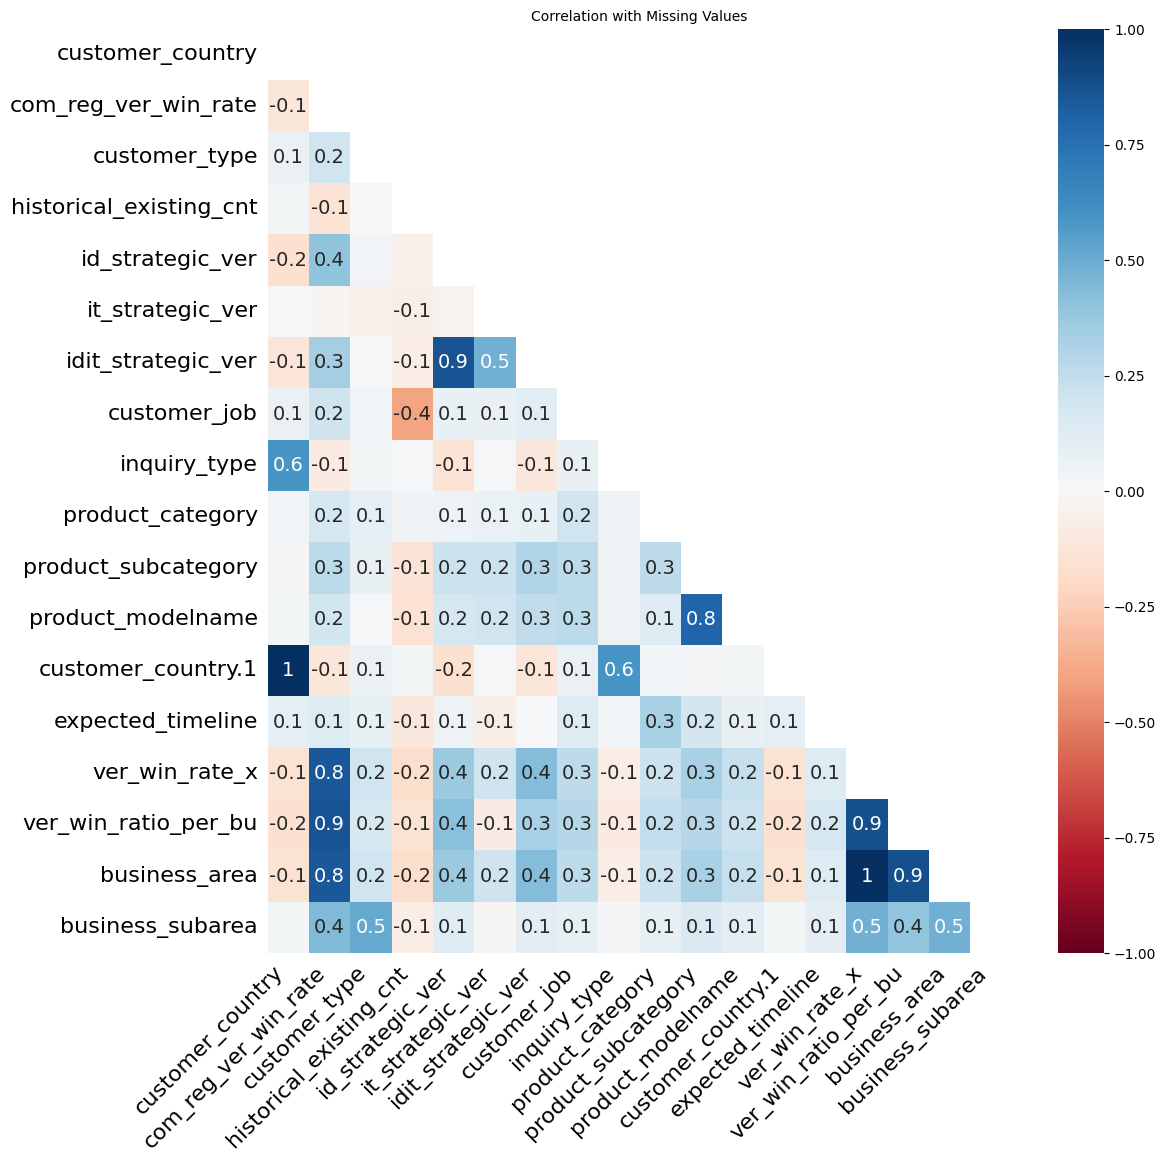

In [11]:
missingdata_df = df_train.columns[df_train.isnull().any()].tolist()
msno.heatmap(df_train[missingdata_df], figsize=(12,12))
plt.title("Correlation with Missing Values", fontsize = 10)

In [12]:
df_train.corr()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,is_converted
bant_submit,1.000000,-0.358328,-0.103236,-0.201929,NaN,NaN,NaN,0.117897,0.100217,0.131256,0.091302,-0.059189,-0.136132,-0.002480
com_reg_ver_win_rate,-0.358328,1.000000,-0.001035,-0.084781,NaN,NaN,NaN,-0.103671,-0.085479,-0.077734,-0.258941,0.446932,0.421827,0.342590
customer_idx,-0.103236,-0.001035,1.000000,0.129121,NaN,NaN,NaN,-0.047099,-0.037796,-0.048979,-0.017452,0.005820,-0.040203,-0.056425
historical_existing_cnt,-0.201929,-0.084781,0.129121,1.000000,NaN,NaN,NaN,0.023398,-0.014322,0.021884,0.078515,0.000799,0.192473,-0.004490
id_strategic_ver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
it_strategic_ver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
idit_strategic_ver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_desc_length,0.117897,-0.103671,-0.047099,0.023398,NaN,NaN,NaN,1.000000,0.092316,0.113362,0.021274,-0.005736,0.039366,0.112822
ver_cus,0.100217,-0.085479,-0.037796,-0.014322,NaN,NaN,NaN,0.092316,1.000000,0.267136,0.278570,-0.025838,0.005361,0.063554
ver_pro,0.131256,-0.077734,-0.048979,0.021884,NaN,NaN,NaN,0.113362,0.267136,1.000000,0.404961,0.175815,0.010284,0.008846


Text(158.22222222222223, 0.5, 'Sample Number')

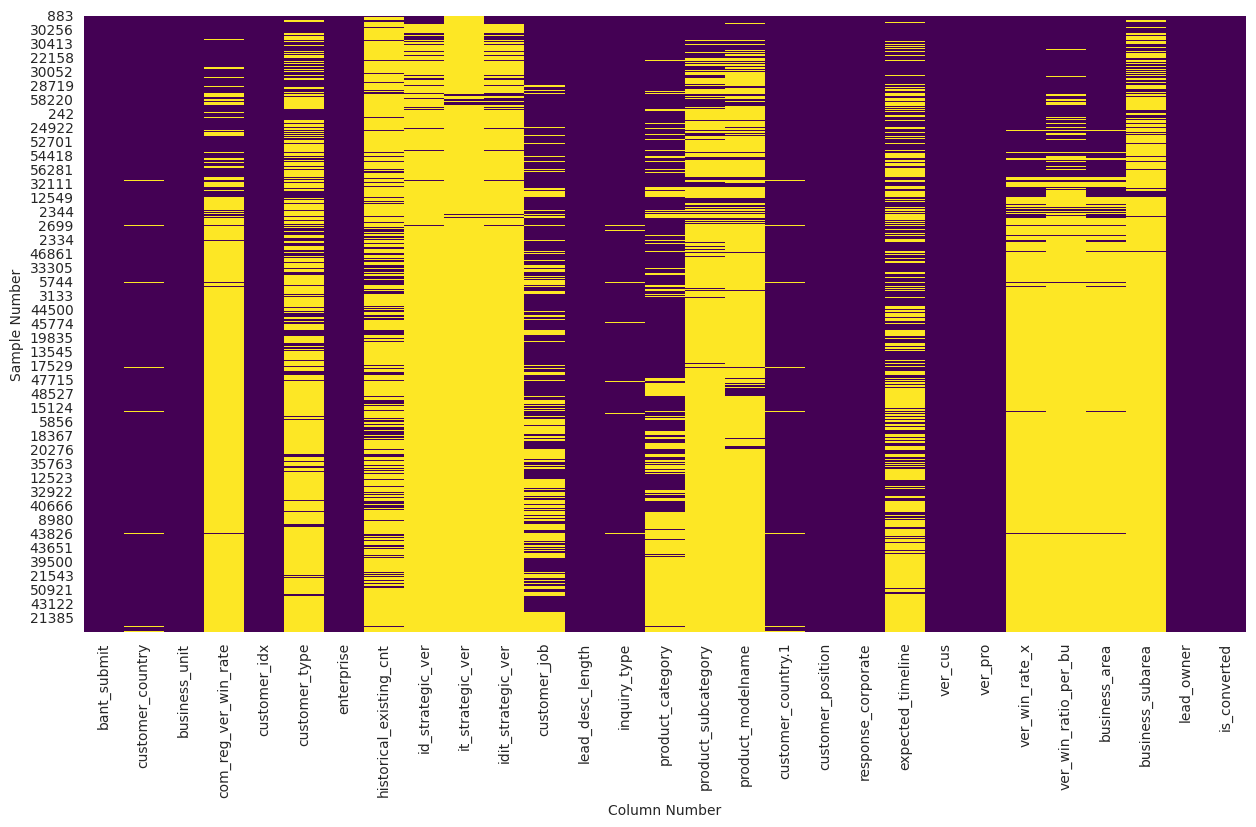

In [13]:
plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')

g = sns.heatmap(df_train.loc[df_train.isnull().sum(1).sort_values(ascending=True).index].isnull(), cbar=False, cmap='viridis')
g.set_xlabel('Column Number')
g.set_ylabel('Sample Number')

In [ ]:
# numeric_columns = df_train.select_dtypes(include='number')
#imputer = IterativeImputer()
#df_train_imputed = pd.DataFrame(imputer.fit_transform(numeric_columns), columns=numeric_columns.columns)
#replacement_values = df_train_imputed.mean()
#print("각 열의 대체값:")
#print(dict(zip(numeric_columns.columns, replacement_values)))

# 각 열의 대체값:
#{'bant_submit': 0.6345933320966627,
# 'com_reg_ver_win_rate': 0.10349573381075637,
# 'customer_idx': 27114.556333159075,
# 'historical_existing_cnt': 15.711868486909403,
# 'id_strategic_ver': 1.0,
#'it_strategic_ver': 1.0,
# 'idit_strategic_ver': 1.0,
#'lead_desc_length': 79.27158974013052,
# 'ver_cus': 0.041602725172431236,
#'ver_pro': 0.05081030034233292,
# 'ver_win_rate_x': 0.0009489601938752031,
# 'ver_win_ratio_per_bu': 0.056072640371732325,
# 'lead_owner': 262.5638880925479}
#
#
# 위에서 빼야 할 데이터 - id_strategic_ver, it_strategic_ver, idit_strategic_ver

In [14]:
numeric_columns = df_train.select_dtypes(include='number')

columns_without_missing_values = numeric_columns.columns[numeric_columns.isnull().sum() == 0]

columns_to_exclude = ['id_strategic_ver', 'it_strategic_ver','idit_strategic_ver']
columns_to_exclude.extend(columns_without_missing_values)

columns_to_impute = numeric_columns.drop(columns=columns_to_exclude, errors='ignore')

imputer = IterativeImputer()

df_train_imputed = pd.DataFrame(imputer.fit_transform(columns_to_impute), columns=columns_to_impute.columns)

replacement_values = df_train_imputed.mean()
print("각 열의 대체값:")
print(dict(zip(columns_to_impute.columns, replacement_values)))



각 열의 대체값:
{'com_reg_ver_win_rate': 0.09232353671310527, 'historical_existing_cnt': 18.33643771017191, 'ver_win_rate_x': 0.0011226202015264572, 'ver_win_ratio_per_bu': 0.055422018203665484}


In [15]:
df_train[columns_to_impute.columns] = df_train_imputed

In [29]:
def extract_country(row):
    parts = str(row).split('/')
    return parts[-1].strip()

df_train['customer_country'] = df_train['customer_country'].astype(str).apply(extract_country)

In [35]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,Philippines,AS,0.066667,32160,End-Customer,Enterprise,-17.842223,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.000000,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,India,AS,0.088889,1755,End-Customer,Enterprise,144.000000,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,India,AS,0.088889,4919,End-Customer,Enterprise,-28.236984,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,-28.236984,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,Poland,AS,0.040282,33747,End Customer,SMB,-3.684583,NaN,NaN,NaN,engineering,200,Product Information,vrf,NaN,NaN,/Sląskie/Poland,entry level,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,-3.552658,NaN,NaN,NaN,entrepreneurship,70,NaN,etc.,NaN,NaN,/Bogotá DC /Colombia,trainee,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,-3.552658,NaN,NaN,NaN,engineering,34,NaN,single-split,NaN,NaN,/Pisco/Peru,entry level,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,Peru,AS,0.040000,40327,NaN,Enterprise,-3.552658,NaN,NaN,NaN,entrepreneurship,377,Quotation or Purchase Consultation,etc.,NaN,NaN,/santa cruz bolivia/Peru,others,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False
